## Titanic Classification Project

In this project I will be exloring the Titantic Dataset in Kaggle with the main to goal being to compare two Classification Algorithms: Logistic Regression & Artificial Neural Networks. Before I apply any machine learning Algorithms I will be performing some Exploratory Data Analysis using Pandas and Seaborn. Then we will attempt to select some of the most relevant features and also consider engineering new ones if necessary. Finally I will use a Logistic regression approach and compare it's accuracy to Artificial Neural Networks.

#### Importing Libraries and the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Exploratory Data Analysis

So it looks like the data set has a range of variables, some Numeric and some Categorical. Let's have a look at the data and see what kind of data cleansing we might need to do as well as which variables are most promising for predicting our target variable 'Survived'.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


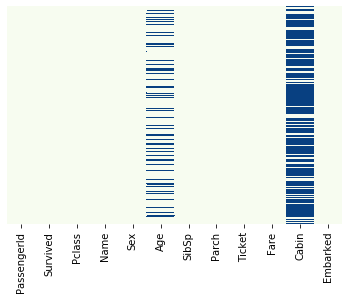

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='GnBu')

It appears as though we have missing data in the 'Age' and 'Cabin' Variables. In fact, the vast majority of Cabin data seems to be missing. It could be that the absence of a Cabin value simply indicates that the passenger did not have a cabin at all, I will change this to be a binary variable, 1 if the pasenger had a Cabin, 0 if not. However, Age would likely play some kind of role in Survival and as only ~20% of this data is missing, let's try to find a way to estimate this from the rest of the data.

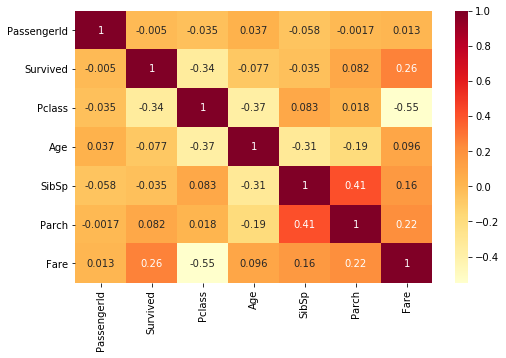

In [6]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(),annot=True,cmap='YlOrRd')

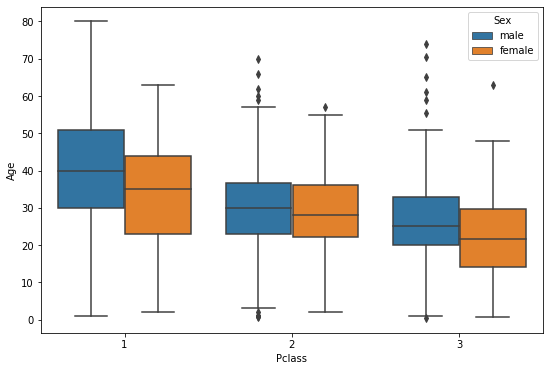

In [7]:
plt.figure(figsize=(9,6))
sns.boxplot(x='Pclass',y='Age',data=df, hue='Sex')

As we can see from the correlation matrix, Age is most strongly correlated (negatively) with Pclass (the type of ticket each passenger had). We could calculate an average age per ticket class, split by gender and use this to fill in any blanks in the age column.

In [8]:
ave_age = df.groupby(['Pclass','Sex']).mean()['Age']
ave_age

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [9]:
def blank_ages(Pclass,Sex,Age):
    if np.isnan(Age):
        return ave_age[Pclass,Sex]
    else:
        return Age

In [10]:
df['Age'] = df.apply(lambda x: blank_ages(x['Pclass'], x['Sex'], x['Age']), axis=1)
test['Age'] = test.apply(lambda x: blank_ages(x['Pclass'], x['Sex'], x['Age']), axis=1)

In [11]:
df['Cabin'] = df['Cabin'].notnull().astype('int')
test['Cabin'] = test['Cabin'].notnull().astype('int')

In [12]:
test['Fare'] = test['Fare'].fillna(0)

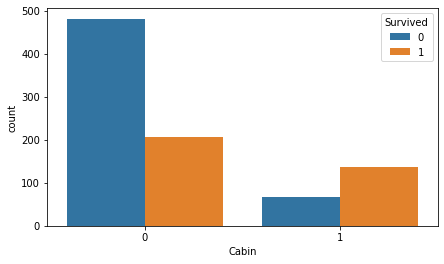

In [13]:
plt.figure(figsize=(7,4))
sns.countplot(x='Cabin',data=df, hue='Survived')

I've created a function which finds Null Ages and maps back to the average age/sex we calculated earlier. After doing this and amending Cabin to present 0/1 we are now not missing Numeric variables. Now lets clean up our categorical variables.

In [14]:
m = {'m' : 1, 'f' : 0}
df['Sex'] = df['Sex'].str[0].str.lower().map(m)
test['Sex'] = test['Sex'].str[0].str.lower().map(m)

In [15]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S


There could be information to be gained from the Name column, however this can be tricky and arguably, titles like 'Miss' implying age and gender can already be inferred from Sex and Age variables. We will drop this column and Ticket, for similar reasons. Additionally, we will attempt to convert Embarked using pd.get_dummies and convert SibSp & Parch into a variable indicating Group Size. Finally we will also convert Pclass using pd.get_dummies, always using drop_first=True so we are not retaining redundant information and introducing multi-collinearity.

In [16]:
embarked_dummies = pd.get_dummies(df['Embarked'], drop_first = True,prefix='Embarked')
df = pd.concat([df.drop('Embarked',axis=1),embarked_dummies],axis=1)

embarked_dummies = pd.get_dummies(test['Embarked'], drop_first = True,prefix='Embarked')
test = pd.concat([test.drop('Embarked',axis=1),embarked_dummies],axis=1)

In [17]:
df = df.drop(['Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)

In [18]:
df['group_size'] = df['SibSp'] + df['Parch'] + 1
df = df.drop(['SibSp', 'Parch'], axis=1)

test['group_size'] = test['SibSp'] + test['Parch'] + 1
test = test.drop(['SibSp', 'Parch'], axis=1)

In [19]:
df['Group_Size'] = pd.cut(df.group_size,bins=[0,1,4,11],labels=['Alone','Small','Large'])
group_dummies = pd.get_dummies(df['Group_Size'], drop_first = True,prefix='Group')
df = pd.concat([df.drop('Group_Size',axis=1),group_dummies],axis=1)
df = df.drop('group_size',axis=1)


test['Group_Size'] = pd.cut(test.group_size,bins=[0,1,4,11],labels=['Alone','Small','Large'])
group_dummies = pd.get_dummies(test['Group_Size'], drop_first = True,prefix='Group')
test = pd.concat([test.drop('Group_Size',axis=1),group_dummies],axis=1)
test = test.drop('group_size',axis=1)

In [20]:
class_dummies = pd.get_dummies(df['Pclass'], drop_first = True,prefix='Class')
df = pd.concat([df.drop('Pclass',axis=1),class_dummies],axis=1)

class_dummies = pd.get_dummies(test['Pclass'], drop_first = True,prefix='Class')
test = pd.concat([test.drop('Pclass',axis=1),class_dummies],axis=1)

In [21]:
df.head()

,PassengerId,Survived,Sex,Age,Fare,Cabin,Embarked_Q,Embarked_S,Group_Small,Group_Large,Class_2,Class_3
0,1,0,1,22.0,7.2500,0,0,1,1,0,0,1
1,2,1,0,38.0,71.2833,1,0,0,1,0,0,0
2,3,1,0,26.0,7.9250,0,0,1,0,0,0,1
3,4,1,0,35.0,53.1000,1,0,1,1,0,0,0
4,5,0,1,35.0,8.0500,0,0,1,0,0,0,1


### Building a Logistic Regression Model

Now that our categorical features have been converted and our data cleansed, we will begin training our model. But first, let's drop PassengerId and then split the data using train/test split. Afterwards, we will also scale our continuous variables (Age & Fare) using sklearn's MinMaxScaler.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [23]:
df = df.drop('PassengerId',axis=1)
test_tf = test.drop('PassengerId',axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived',axis=1), 
                                                    df['Survived'], test_size=0.30, 
                                                    random_state=101)

In [25]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_tf = scaler.transform(test_tf)

In [26]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
predictions = logmodel.predict(X_test)

In [28]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[137  17]
 [ 38  76]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       154
           1       0.82      0.67      0.73       114

    accuracy                           0.79       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.79      0.79       268



### Evaluating Model Performance

After running Logisitic Regression we can see that of our 268 test examples we correctly predicted 76 survivals and 137 deaths, with 17 False Positives and 38 False Negatives. Our accuracy was 79%, not bad! Now let's see how an Artificial Neural Network would perform.

### Artificial Neural Networks with Tensorflow

Using tensorflow.keras we will build and a Sequential model with 10 input nodes (1 node per variable), two hidden layers with relu activation functions (rectified linear unit) and an output node with sigmoid activation predicting either survival or not.

As this is a relatively small dataset we don't need to worry too much about computational cost, as a result I have arbitrarily set epochs to 1,000, with an early stopping callback. Additionally, to prevent overfitting to the training set I have added dropout to my hidden layers with a rate of 20%. I will then plot training loss vs. validation loss.

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
test_tf = test.drop('PassengerId',axis=1)
X = df.drop('Survived',axis=1).values
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_tf = scaler.transform(test_tf)

In [32]:
model = Sequential()

model.add(Dense(10,  activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [33]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop] 
          )

Train on 623 samples, validate on 268 samples
Epoch 1/1000
623/623 [==============================] - 1s 2ms/sample - loss: 0.7095 - val_loss: 0.6864
Epoch 2/1000
623/623 [==============================] - 0s 172us/sample - loss: 0.6849 - val_loss: 0.6782
Epoch 3/1000
623/623 [==============================] - 0s 186us/sample - loss: 0.6783 - val_loss: 0.6706
Epoch 4/1000
623/623 [==============================] - 0s 151us/sample - loss: 0.6678 - val_loss: 0.6622
Epoch 5/1000
623/623 [==============================] - 0s 149us/sample - loss: 0.6527 - val_loss: 0.6504
Epoch 6/1000
623/623 [==============================] - 0s 172us/sample - loss: 0.6428 - val_loss: 0.6403
Epoch 7/1000
623/623 [==============================] - 0s 172us/sample - loss: 0.6307 - val_loss: 0.6261
Epoch 8/1000
623/623 [==============================] - 0s 154us/sample - loss: 0.6086 - val_loss: 0.6112
Epoch 9/1000
623/623 [==============================] - 0s 172us/sample - loss: 0.5793 - val_loss: 0.5849
Ep

623/623 [==============================] - 0s 104us/sample - loss: 0.4459 - val_loss: 0.4454
Epoch 78/1000
623/623 [==============================] - 0s 101us/sample - loss: 0.4333 - val_loss: 0.4480
Epoch 79/1000
623/623 [==============================] - 0s 96us/sample - loss: 0.4461 - val_loss: 0.4508
Epoch 80/1000
623/623 [==============================] - 0s 96us/sample - loss: 0.4333 - val_loss: 0.4500
Epoch 81/1000
623/623 [==============================] - 0s 106us/sample - loss: 0.4348 - val_loss: 0.4490
Epoch 82/1000
623/623 [==============================] - 0s 106us/sample - loss: 0.4367 - val_loss: 0.4495
Epoch 83/1000
623/623 [==============================] - 0s 106us/sample - loss: 0.4328 - val_loss: 0.4468
Epoch 84/1000
623/623 [==============================] - 0s 96us/sample - loss: 0.4251 - val_loss: 0.4450
Epoch 85/1000
623/623 [==============================] - 0s 106us/sample - loss: 0.4346 - val_loss: 0.4488
Epoch 86/1000
623/623 [==============================]

(0.35, 0.75)

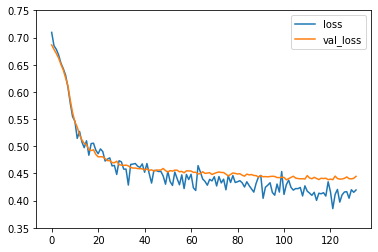

In [34]:
model.save('Titanic_Model.h5')  
losses = pd.DataFrame(model.history.history)
plt = losses[['loss','val_loss']].plot()
plt.set_ylim([0.35,0.75])

In [35]:
predictions = model.predict_classes(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[143  11]
 [ 41  73]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       154
           1       0.87      0.64      0.74       114

    accuracy                           0.81       268
   macro avg       0.82      0.78      0.79       268
weighted avg       0.82      0.81      0.80       268



### Conclusion

Our model trained for 464 epochs before the callback function stopped training. As we can see, we have achieved an accuracy of 81%, which is a slight improvement on our Logistic regression score of 79%.

Potential improvements could revolve around more feature engineering, perhaps by utilising the name variable, or looking more into ticket numbers. However, this is likely to only provide marginal gains. Additionally, it would be worth investigating the performance of other algorithms such as Random forest classifiers or Support Vector Machines.

In [36]:
test_pred = model.predict_classes(test_tf)

In [37]:
passengerId = test['PassengerId']
passengerId = pd.DataFrame(passengerId)
submission = pd.concat([
    passengerId,
    pd.DataFrame(test_pred, dtype=np.int)
], axis=1, ignore_index=True)

In [38]:
submission.to_csv('submission_ann.csv', index=False)